In [3]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
# from keras.utils import plot_model

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D


#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import os
os.chdir('/content/drive/MyDrive/신입기수 프로젝트/Dataset')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
raw_data = pd.read_csv('rawdata.csv')
raw_data = raw_data[:-6912]

In [6]:
# 날짜를 index로 바꾸고 dtype을 datetime으로 바꾸기
raw_data.set_index(keys = ['날짜'], inplace = True)
raw_data.index = pd.to_datetime(raw_data.index, format = '%Y-%m-%d %H:%M')

In [7]:
raw_data.isnull().sum()

현재수위          707
유입량           707
저수량           707
공용량           707
방류량           707
강화대교_조위      4923
청담대교_유량     15164
잠수교_유량     189937
한강대교_유량      1279
행주대교_유량        59
대곡교_강수량         0
진관교_강수량         0
송정동_강수량         0
청담대교_수위        59
잠수교_수위         59
한강대교_수위        59
행주대교_수위        59
dtype: int64

In [8]:
raw_data

,현재수위,유입량,저수량,공용량,방류량,강화대교_조위,청담대교_유량,잠수교_유량,한강대교_유량,행주대교_유량,대곡교_강수량,진관교_강수량,송정동_강수량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
날짜,,,,,,,,,,,,,,,,,
2012-05-01 00:00:00,24.800,555.00,219.07,24.93,555.00,445.0,469.05,0.0,729.80,540.18,0.0,0.0,0.0,310.7,300.2,290.0,275.3
2012-05-01 00:10:00,24.794,464.60,218.86,25.15,562.90,449.0,498.00,0.0,731.48,540.18,0.0,0.0,0.0,314.7,300.2,290.0,275.3
2012-05-01 00:20:00,24.789,478.10,218.69,25.31,576.40,451.0,490.68,0.0,726.42,540.18,0.0,0.0,0.0,313.7,301.2,290.0,275.3
2012-05-01 00:30:00,24.789,464.80,218.69,25.31,563.10,452.0,476.21,0.0,726.42,552.17,0.0,0.0,0.0,311.7,301.2,290.0,276.3
2012-05-01 00:40:00,24.789,478.10,218.69,25.31,576.40,450.0,476.21,0.0,707.17,564.29,0.0,0.0,0.0,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31 23:10:00,25.180,140.94,217.99,26.01,140.94,220.0,285.72,NaN,575.57,493.58,0.0,0.0,0.0,281.7,281.2,278.0,271.3
2022-05-31 23:20:00,25.180,141.07,217.99,26.01,141.07,208.0,274.78,NaN,501.04,505.03,0.0,0.0,0.0,279.7,279.2,278.0,272.3
2022-05-31 23:30:00,25.180,141.01,217.99,26.01,141.01,196.0,269.40,NaN,425.89,505.03,0.0,0.0,0.0,278.7,277.2,277.0,272.3


In [12]:
from glob import glob

xdata = pd.read_csv("xdata.csv", encoding = 'cp949')
xdata

,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,540.18,310.7,300.2,290.0,275.3
1,540.18,314.7,300.2,290.0,275.3
2,540.18,313.7,301.2,290.0,275.3
3,552.17,311.7,301.2,290.0,276.3
4,564.29,311.7,301.2,291.0,277.3
...,...,...,...,...,...
276331,974.40,0.0,0.0,0.0,0.0
276332,1006.88,0.0,0.0,0.0,0.0
276333,1039.90,0.0,0.0,0.0,0.0
276334,1073.46,0.0,0.0,0.0,0.0


In [13]:
xdata = xdata[:-6912]
xdata

,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,540.18,310.7,300.2,290.0,275.3
1,540.18,314.7,300.2,290.0,275.3
2,540.18,313.7,301.2,290.0,275.3
3,552.17,311.7,301.2,290.0,276.3
4,564.29,311.7,301.2,291.0,277.3
...,...,...,...,...,...
269419,493.58,281.7,281.2,278.0,271.3
269420,505.03,279.7,279.2,278.0,272.3
269421,505.03,278.7,277.2,277.0,272.3
269422,493.58,277.7,276.2,276.0,271.3


In [14]:
# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = xdata.copy()

for i in range(len(xdata.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x



# 원하는 칼럼명 입력하기

In [15]:
#ydata = raw_data[['현재수위','유입량','저수량','공용량','방류량','강화대교_조위','청담대교_유량','잠수교_유량','한강대교_유량']]
ydata = raw_data[['한강대교_유량']]

# 원하는 칼럼명 입력하기

In [16]:
ydata = ydata.reset_index()
ydata = ydata.한강대교_유량
ydata = pd.DataFrame(ydata)
ydata

,한강대교_유량
0,729.80
1,731.48
2,726.42
3,726.42
4,707.17
...,...
269419,575.57
269420,501.04
269421,425.89
269422,198.19


In [17]:
input_regular = pd.concat([input_x_regular, ydata], axis = 1)
input_regular

,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,한강대교_유량
0,0.011070,0.049611,0.060000,0.051621,0.126469,729.80
1,0.011070,0.053502,0.060000,0.051621,0.126469,731.48
2,0.011070,0.052529,0.061111,0.051621,0.126469,726.42
3,0.011475,0.050584,0.061111,0.051621,0.128007,726.42
4,0.011883,0.050584,0.061111,0.052821,0.129545,707.17
...,...,...,...,...,...,...
269419,0.009498,0.021401,0.038889,0.037215,0.120317,575.57
269420,0.009884,0.019455,0.036667,0.037215,0.121855,501.04
269421,0.009884,0.018482,0.034444,0.036014,0.121855,425.89
269422,0.009498,0.017510,0.033333,0.034814,0.120317,198.19


# 원하는 칼럼명 입력하기

In [18]:
input_y_ = input_regular[['한강대교_유량']]
input_x_ = input_regular.drop(input_y_.columns, axis = 1)

In [19]:
input_x_

,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,0.011070,0.049611,0.060000,0.051621,0.126469
1,0.011070,0.053502,0.060000,0.051621,0.126469
2,0.011070,0.052529,0.061111,0.051621,0.126469
3,0.011475,0.050584,0.061111,0.051621,0.128007
4,0.011883,0.050584,0.061111,0.052821,0.129545
...,...,...,...,...,...
269419,0.009498,0.021401,0.038889,0.037215,0.120317
269420,0.009884,0.019455,0.036667,0.037215,0.121855
269421,0.009884,0.018482,0.034444,0.036014,0.121855
269422,0.009498,0.017510,0.033333,0.034814,0.120317


In [20]:
input_y_.isnull().sum()

한강대교_유량    1279
dtype: int64

# 원하는 칼럼명 입력하기

In [21]:
nanIndex = input_y_[input_y_['한강대교_유량'].isnull() == True].index

In [22]:
nanIndex

Int64Index([ 91352,  91353,  91354,  91355,  91356,  91357,  91358,  91359,
             91360,  91361,
            ...
            262125, 262126, 262127, 262128, 262129, 262130, 262131, 262132,
            262133, 262134],
           dtype='int64', length=1279)

In [23]:
from tqdm import tqdm

xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-1]
for i in range(len(input_regular.columns)-1):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████| 11/11 [02:25<00:00, 13.24s/it]


In [24]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(269358, 6, 5)
(269358, 1)


In [25]:
# 나중에 학습된 모델에 이거 넣어서 predict해서 결측치 채우기
x_real_predict = []
y_real_predict = []

for i in range(len(nanIndex)):
    k = nanIndex[-(i+1)]
    
    x_real_predict.insert(0,(xdata[k - w * (k // 26496 + 1)]))
    y_real_predict.insert(0,(ydata[k - w * (k // 26496 + 1)]))
    
    xdata.pop(k - 6 * (k // 26496 + 1))
    ydata.pop(k - 6 * (k // 26496 + 1))

In [26]:
print(np.array(x_real_predict).shape)
print(np.array(y_real_predict).shape)

(1279, 6, 5)
(1279, 1)


In [27]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(268079, 6, 5)
(268079, 1)


In [28]:
pd.DataFrame(ydata).isnull().sum()

0    0
dtype: int64

In [29]:
xtrain = np.array(xdata[:-50000])
ytrain = np.array(ydata[:-50000])

xtest = np.array(xdata[-50000:])
ytest = np.array(ydata[-50000:])

In [30]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(218079, 6, 5)
(218079, 1)
(50000, 6, 5)
(50000, 1)


## 모델 생성

In [31]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu', input_shape=(w, xtrain.shape[2])))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(1))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =["accuracy"])

model_enc_dec_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             704       
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 64)             8256      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 192)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 1, 200)            3

In [32]:
# plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [33]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=0.001)

In [34]:
## 학습

history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
801/801 [==============================] - 91s 102ms/step - loss: 368.7477 - accuracy: 1.8342e-04 - val_loss: 184.2800 - val_accuracy: 4.5855e-05 - lr: 0.0100
Epoch 2/100
801/801 [==============================] - 80s 99ms/step - loss: 217.6313 - accuracy: 2.5220e-04 - val_loss: 159.1796 - val_accuracy: 1.6049e-04 - lr: 0.0100
Epoch 3/100
801/801 [==============================] - 81s 101ms/step - loss: 198.0506 - accuracy: 2.8086e-04 - val_loss: 155.2501 - val_accuracy: 9.1709e-05 - lr: 0.0100
Epoch 4/100
801/801 [==============================] - 78s 97ms/step - loss: 185.2717 - accuracy: 2.4647e-04 - val_loss: 162.6708 - val_accuracy: 6.8782e-05 - lr: 0.0100
Epoch 5/100
801/801 [==============================] - 82s 102ms/step - loss: 174.1189 - accuracy: 2.1781e-04 - val_loss: 154.9425 - val_accuracy: 1.3756e-04 - lr: 0.0100
Epoch 6/100
801/801 [==============================] - 84s 105ms/step - loss: 168.1394 - accuracy: 2.4074e-04 - val_loss: 145.5202 - val_accuracy: 

In [36]:
## 평가

keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

yhat = keras_model_best.predict(xtest, verbose=1)

yhat

keras_model_best.evaluate(xtest,ytest)

1563/1563 [==============================] - 19s 12ms/step - loss: 278.7704 - accuracy: 3.8000e-04


[278.7703552246094, 0.0003800000122282654]

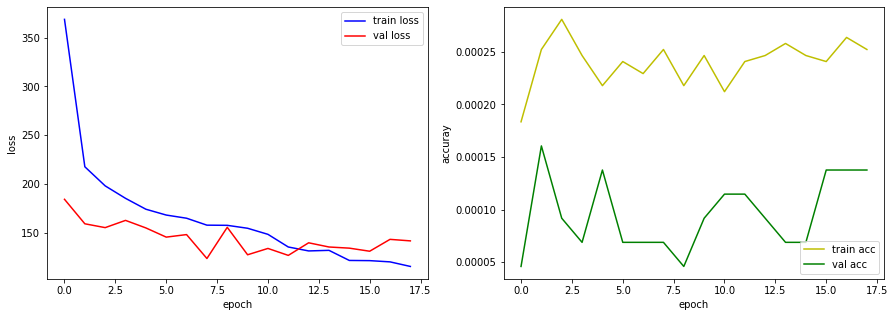

In [37]:
## 학습 과정 시각화

fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['accuracy'], 'y', label='train acc')
loss_ax[1].plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('accuray')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

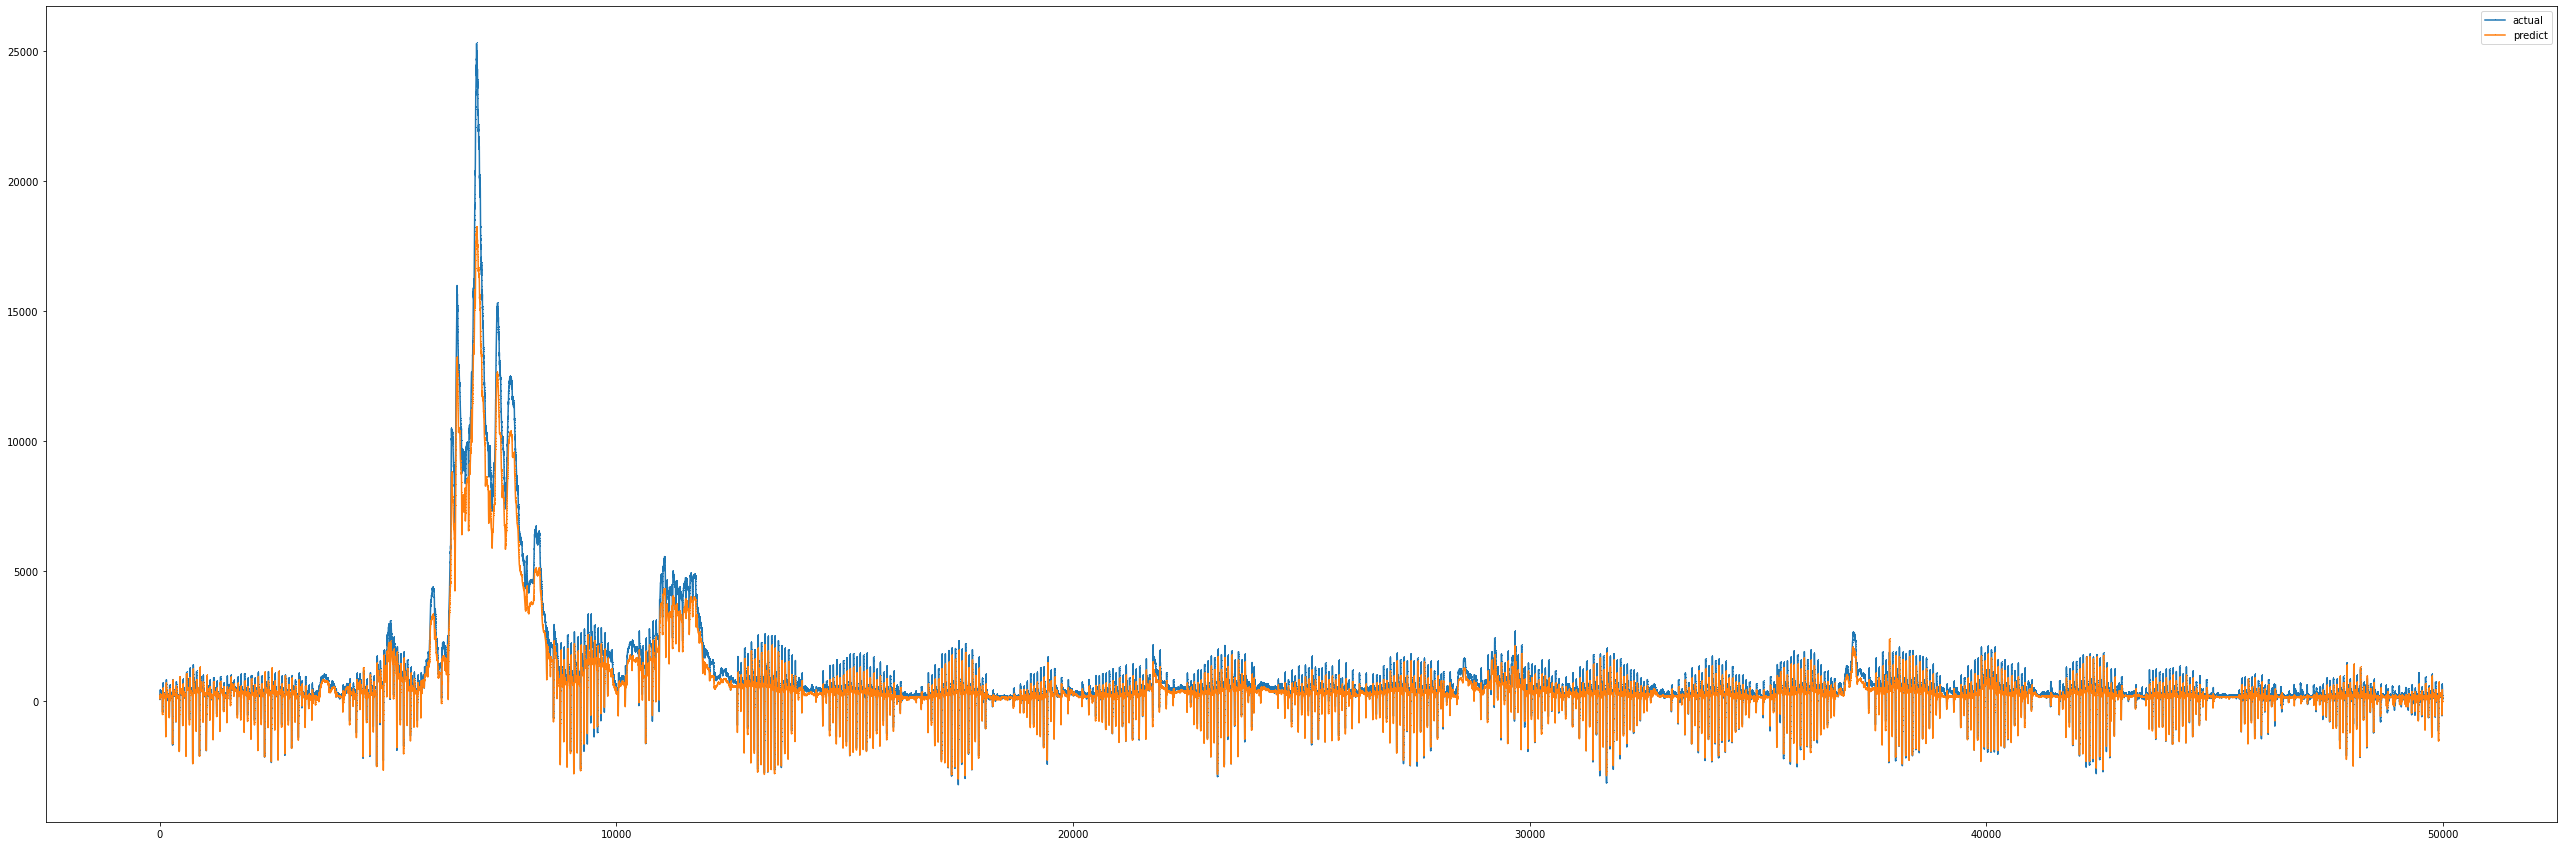

In [40]:
## 결과 시각화

tl_predict = np.array(yhat)

#결과 시각화
plt.figure(figsize=(45,15))
plt.plot(ytest, marker = ",", label = "actual")
plt.plot(tl_predict, marker = ",", label="predict")
plt.legend(prop={'size':10})  

plt.show()

In [ ]:
## 점수 확인
float(root_mean_squared_error(ytest, tl_predict))

281.04944386752254

## 파일 저장
마지막 6912개는 없는 데이터임

# 원하는 칼럼명 입력하기

In [ ]:
raw_data2 = pd.read_csv('C:/Users/sjkan/Desktop/연세/YBIGTA/22 여름방학/신입기수프로젝트/rawdata.csv')
raw_data2 = raw_data2[:-6912]
predict_dataset = raw_data2['한강대교_유량']

In [ ]:
predict_dataset.info()

<class 'pandas.core.series.Series'>
RangeIndex: 269424 entries, 0 to 269423
Series name: 한강대교_유량
Non-Null Count   Dtype  
--------------   -----  
268145 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [ ]:
predict_dataset.isnull().sum()

1279

In [ ]:
nanIndex[2]

91354

In [ ]:
predict_dataset.iloc[nanIndex[2]]

nan

In [ ]:
y_real_predict

[array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([na

In [ ]:
test_input = np.array(x_real_predict)
y_real_hat = keras_model_best.predict(test_input, verbose=1)

40/40 [==============================] - 0s 5ms/step


In [ ]:
y_real_hat

array([[191.50314],
       [194.84789],
       [194.865  ],
       ...,
       [266.41357],
       [276.66214],
       [269.51297]], dtype=float32)

In [ ]:
predict_dataset.info()

<class 'pandas.core.series.Series'>
RangeIndex: 269424 entries, 0 to 269423
Series name: 한강대교_유량
Non-Null Count   Dtype  
--------------   -----  
268145 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [ ]:
predict_dataset.isnull().sum()

1279

In [ ]:
for i in range(len(nanIndex)):
    predict_dataset.iloc[nanIndex[i]] = np.float64(y_real_hat[i])

In [ ]:
predict_dataset.info()

<class 'pandas.core.series.Series'>
RangeIndex: 269424 entries, 0 to 269423
Series name: 한강대교_유량
Non-Null Count   Dtype  
--------------   -----  
269424 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [ ]:
predict_dataset.isnull().sum()

0

# 원하는 칼럼명 입력하기

In [ ]:
predict_dataset.to_csv('한강대교_유량.csv', index = False)